## Scalable parallel execution

* Image color conversion
* Image blur

@Martin Samouiller

In [ ]:
from numba import cuda
import numpy as np
from numba import jit
import math
from numba import float32
import timeit
from timeit import time

In [ ]:
print(cuda.gpus)

In [2]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [3]:
# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

# Color to greyscale conversion

first cuda kernel in python 
Image color conversion

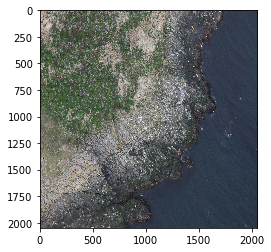

(2048, 2048, 3)

In [186]:
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt

path = 'D:/Data/images/4-1.tif'

im = ndimage.imread(path)

plt.imshow(im)
plt.show()
im.shape

In [191]:
im[2047,2047,0]
Pout = np.zeros(shape=(h,w), dtype=im.dtype)
Pout[2048,2048] = im[2047,2047,0]

IndexError: index 2048 is out of bounds for axis 0 with size 2048

In [194]:
def colorToGreyScaleConversionPure(im):
    
    h,w,d = im.shape
    print(im.shape)
    Pout = np.zeros(shape=(h,w), dtype=im.dtype)
    print(Pout.shape)
    
    for y in np.arange(0, h):
        for x in np.arange(0, w):
            
            r = float(im[y,x,0]);
            g = float(im[y,x,1]);
            b = float(im[y,x,2]);
        
            #print("value: " , int(0.21*r+0.71*g+0.07*b))
            Pout[y,x] = int(0.21*r+0.71*g+0.07*b)
            
        
    return Pout           

(2048, 2048, 3)
(2048, 2048)
pure python color conversion took :  4.4688920974731445 seconds


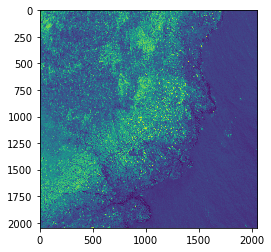

In [196]:
starttime = time.time()
C = colorToGreyScaleConversionPure(im)
end_time = time.time()
secs = end_time - starttime
print('pure python color conversion took : ', secs, 'seconds')

plt.imshow(C)
plt.show()

misc.imsave('test.jpg', C)

In [195]:
def colorToGreyScaleConversionNumpy(rgb):
    return np.dot(rgb[...,:3], [0.21, 0.71, 0.07])

Numpy python color conversion took :  0.09926581382751465 seconds


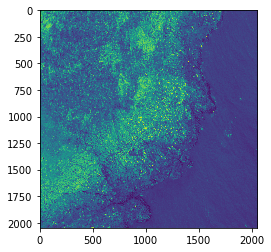

In [197]:
starttime = time.time()
C = colorToGreyScaleConversionNumpy(im)
end_time = time.time()
secs = end_time - starttime
print('Numpy python color conversion took : ', secs, 'seconds')

plt.imshow(C)
plt.show()

misc.imsave('test.jpg', C)

In [198]:
imf = im.astype(np.float32)
print('im type : ', imf.dtype, ' -- im shape', imf.shape)

#imC = np.zeros((imf.shape[0], imf.shape[1]), dtype=imf.dtype)
#print('im type : ', imC.dtype, ' -- im shape', imC.shape)

im type :  float32  -- im shape (2048, 2048, 3)


In [199]:
@cuda.jit
def colorToGreyScaleConversion(imageOut, image):

    height = image.shape[0]
    width = image.shape[1]
    
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    # assuming x and y inputs are same length
    if x < width and y < height:
        
        r = image[y,x,0];
        g = image[y,x,1];
        b = image[y,x,2];
        
        imageOut[y,x] = 0.21*r+0.71*g+0.07*b

WARP size 32
Blocks per grid: (128, 128)
Threads per block (16, 16)
CUDA python color conversion took with allocation :  0.020555973052978516 seconds


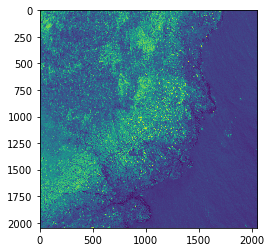

In [203]:
starttime = time.time()

device = cuda.get_current_device()

# Copy the arrays to the device
IM_global_mem = cuda.to_device(imf)

# Allocate memory on the device for the result
C_global_mem = cuda.device_array(shape=(imf.shape[0], imf.shape[1]), dtype=np.float32)

DIM = 2048

grids = (int(math.ceil(DIM / 16)), int(math.ceil(DIM / 16)))
threads = (16, 16)

# Set up enough threads for kernel
tpb = device.WARP_SIZE
print( 'WARP size', device.WARP_SIZE)
print( 'Blocks per grid:', grids)
print( 'Threads per block', threads)


# Start the kernel 
colorToGreyScaleConversion[grids, threads](C_global_mem, IM_global_mem)

# Copy the result back to the host
C = C_global_mem.copy_to_host()

end_time = time.time()
secs = end_time - starttime
print('CUDA python color conversion took with allocation : ', secs, 'seconds')

#C_bis = C.reshape((im.shape[0],im.shape[1]))
                       
plt.imshow(C)
plt.show()

misc.imsave('test.jpg', C)

In [158]:
starttime = time.time()
colorToGreyScaleConversion[grids, threads](C_global_mem, IM_global_mem)
end_time = time.time()
secs = end_time - starttime
print('CUDA python color conversion took : ', secs, 'seconds')

CUDA python color conversion took :  0.0005016326904296875 seconds


In [142]:
# Start the kernel 
%timeit colorToGreyScaleConversion[grids, threads](C_global_mem, IM_global_mem)

332 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


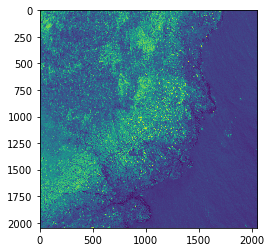

Comparaison Color conversion

Python pure : 5.83 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Python CUDA Numba : 332 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [160]:
print('improvement : ', 5.992427587509155/0.020554065704345703 )

improvement :  291.54463519313305
